<a href="https://colab.research.google.com/github/nizar7702/ESG_countries_north_africa/blob/main/NLP_task_Social_pillar_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#!pip install PyMuPDF pdfminer.six python-docx
#!pip install sentence-transformers nltk vaderSentiment
#!python -m nltk.downloader punkt stopwords

In [58]:
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/NLP"

In [59]:
INDICATORS = {
    # --- Access to Services ---
    "clean_fuels": {
        "keywords": [
            "access to clean fuels", "clean cooking technologies",
            "clean fuels for cooking", "modern cooking fuels",
            "safe cooking technologies"
        ],
        "regex": [r"\bclean (?:fuels|technologies)\b.*\b(cooking)\b"]
    },
    "electricity": {
        "keywords": [
            "access to electricity", "electrification rate", "electricity access",
            "household electrification", "power access", "grid connection",
            "electric grid", "energy access", "rural electrification"
        ],
        "regex": [r"\belectricity\b.*\b(percent|%)\b"]
    },
    "drinking_water": {
        "keywords": [
            "safely managed drinking water", "access to drinking water",
            "safe water services", "clean water access"
        ],
        "regex": [r"\bdrinking water\b.*\b(percent|%)\b"]
    },
    "sanitation": {
        "keywords": [
            "safely managed sanitation", "sanitation services",
            "access to sanitation", "toilet facilities"
        ],
        "regex": [r"\bsanitation\b.*\b(percent|%)\b"]
    },

    # --- Demography ---
    "life_expectancy": {
        "keywords": ["life expectancy", "longevity", "average lifespan"],
        "regex": [r"\blife expectancy\b.*\byears\b"]
    },
    "fertility_rate": {
        "keywords": ["fertility rate", "births per woman", "average fertility"],
        "regex": [r"\bfertility rate\b.*\bbirths\b"]
    },
    "population_65plus": {
        "keywords": [
            "population ages 65 and above", "elderly population",
            "senior citizens", "older adults"
        ],
        "regex": [r"\b65\b.*\bpercent\b"]
    },

    # --- Education & Skills ---
    "literacy": {
        "keywords": [
            "literacy rate", "adult literacy", "reading proficiency",
            "illiteracy rate", "basic literacy"
        ],
        "regex": [r"\bliteracy\b.*\b(percent|%)\b"]
    },
    "school_enrollment": {
        "keywords": [
            "school enrollment", "primary enrollment", "gross enrollment",
            "education enrollment"
        ],
        "regex": [r"\benrollment\b.*\b(percent|%)\b"]
    },
    "education_expenditure": {
        "keywords": [
            "government expenditure on education", "education spending",
            "education budget", "education expenditure"
        ],
        "regex": [r"\beducation\b.*\bexpenditure\b"]
    },

    # --- Employment ---
    "child_employment": {
        "keywords": [
            "children in employment", "child labor", "child workforce"
        ],
        "regex": [r"\bchild(?:ren)? employment\b"]
    },
    "labor_force_participation": {
        "keywords": [
            "labor force participation rate", "workforce participation",
            "employment participation"
        ],
        "regex": [r"\blabor force participation\b"]
    },
    "unemployment": {
        "keywords": [
            "unemployment rate", "joblessness", "jobless rate",
            "youth unemployment", "female unemployment"
        ],
        "regex": [r"\bunemployment\b.*\b(percent|%)\b"]
    },

    # --- Health & Nutrition ---
    "cause_of_death": {
        "keywords": [
            "cause of death by communicable diseases",
            "maternal conditions", "prenatal conditions",
            "nutrition conditions"
        ],
        "regex": [r"\bcause of death\b"]
    },
    "mortality_under5": {
        "keywords": [
            "under-5 mortality", "child mortality", "infant mortality",
            "neonatal mortality"
        ],
        "regex": [r"\bunder[- ]?5 mortality\b"]
    },
    "hospital_beds": {
        "keywords": [
            "hospital beds per 1,000 people", "hospital capacity",
            "bed availability"
        ],
        "regex": [r"\bhospital beds\b"]
    },
    "undernourishment": {
        "keywords": [
            "prevalence of undernourishment", "undernourished population",
            "hunger prevalence"
        ],
        "regex": [r"\bundernourishment\b"]
    },
    "overweight": {
        "keywords": [
            "prevalence of overweight", "adult overweight",
            "obesity prevalence"
        ],
        "regex": [r"\boverweight\b"]
    },

    # --- Poverty & Inequality ---
    "income_share_lowest20": {
        "keywords": [
            "income share held by lowest 20%", "lowest quintile income share"
        ],
        "regex": [r"\blowest 20%\b.*\bincome\b"]
    },
    "poverty_headcount_3usd": {
        "keywords": [
            "poverty headcount ratio at $3.00 a day", "poverty at 3 dollars",
            "poverty line 3 USD"
        ],
        "regex": [r"\bpoverty\b.*\$3"]
    },
    "gini": {
        "keywords": [
            "gini index", "gini coefficient", "income inequality"
        ],
        "regex": [r"\bgini\b"]
    },
    "poverty_headcount_national": {
        "keywords": [
            "poverty headcount ratio at national poverty lines",
            "national poverty line"
        ],
        "regex": [r"\bnational poverty line\b"]
    },
    "poverty_headcount_8usd": {
        "keywords": [
            "poverty headcount ratio at $8.30 a day", "poverty at 8 dollars",
            "poverty line 8 USD"
        ],
        "regex": [r"\bpoverty\b.*\$8"]
    },
    "prosperity_gap": {
        "keywords": [
            "prosperity gap", "average shortfall from prosperity standard",
            "prosperity shortfall"
        ],
        "regex": [r"\bprosperity gap\b"]
    }
}

In [60]:
import fitz, re

def read_pdf(path):
    text = []
    with fitz.open(path) as doc:
        for page in doc:
            text.append(page.get_text("text"))
    return "\n".join(text)

def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"Page\s+\d+", " ", text)
    return text.strip()

In [61]:
from nltk.tokenize import sent_tokenize, word_tokenize

def chunk_text(text, max_tokens=800):
    sents = sent_tokenize(text)
    chunks, current, count = [], [], 0
    for s in sents:
        n = len(word_tokenize(s))
        if count + n <= max_tokens:
            current.append(s); count += n
        else:
            if current: chunks.append(" ".join(current))
            current, count = [s], n
    if current: chunks.append(" ".join(current))
    return chunks

In [62]:
def find_indicator_mentions(chunk, indicators=INDICATORS):
    t = chunk.lower()
    hits = []
    for ind, cfg in indicators.items():
        if any(k.lower() in t for k in cfg["keywords"]):
            hits.append(ind)
        else:
            for rx in cfg["regex"]:
                if re.search(rx, t, flags=re.IGNORECASE):
                    hits.append(ind); break
    return list(set(hits))

In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np

analyzer = SentimentIntensityAnalyzer()

def sentiment_per_indicator(chunks):
    scores = {}
    for c in chunks:
        inds = find_indicator_mentions(c)
        if inds:
            s = analyzer.polarity_scores(c)["compound"]
            for ind in inds:
                scores.setdefault(ind, []).append(s)
    return {ind: float(np.mean(vals)) for ind, vals in scores.items()}

In [64]:
def compute_avg_score(indicator_scores, all_indicators):
    # Fill missing indicators with neutral sentiment (0)
    filled_scores = {ind: indicator_scores.get(ind, 0.0) for ind in all_indicators}
    raw_avg = np.mean(list(filled_scores.values()))  # –1 to +1
    rescaled = ((raw_avg + 1) / 2) * 100              # 0 to 100
    return rescaled, filled_scores

In [65]:
import os, pandas as pd

all_indicators = list(INDICATORS.keys())
results = []

for country in os.listdir(DATA_ROOT):
    cpath = os.path.join(DATA_ROOT, country)
    if not os.path.isdir(cpath): continue
    for fname in os.listdir(cpath):
        if not fname.endswith(".pdf"): continue
        try:
            year = int(fname.split("_")[0])
        except:
            continue
        path = os.path.join(cpath, fname)

        raw = read_pdf(path)
        clean = clean_text(raw)
        chunks = chunk_text(clean)
        ind_scores = sentiment_per_indicator(chunks)
        avg_score, filled_scores = compute_avg_score(ind_scores, all_indicators)

        row = {
            "country": country,
            "year": year,
            "S_score_avg_rescaled": avg_score
        }
        for ind in all_indicators:
            row[f"{ind}_sent"] = filled_scores[ind]
        results.append(row)

df = pd.DataFrame(results).sort_values(["country", "year"])

In [66]:
# Identify indicator columns
indicator_cols = [col for col in df.columns if col.endswith("_sent")]

# Drop columns where all values are exactly 0.0
for col in indicator_cols:
    if df[col].eq(0.0).all():
        df.drop(columns=col, inplace=True)

# Recompute ESG score after dropping unused indicators
remaining_indicators = [col for col in df.columns if col.endswith("_sent")]
df["S_score_avg_rescaled"] = ((df[remaining_indicators].mean(axis=1)) + 1) / 2 * 100

# Save cleaned CSV
df.to_csv("/content/drive/MyDrive/nlp_results_with_avg.csv", index=False)
df.head()

,country,year,S_score_avg_rescaled,electricity_sent,drinking_water_sent,sanitation_sent,life_expectancy_sent,fertility_rate_sent,population_65plus_sent,literacy_sent,...,child_employment_sent,labor_force_participation_sent,unemployment_sent,mortality_under5_sent,hospital_beds_sent,overweight_sent,poverty_headcount_3usd_sent,gini_sent,poverty_headcount_national_sent,poverty_headcount_8usd_sent
14,Algeria,2021,41.695357,0.0000,-0.6369,-0.1414,-0.522914,-0.545067,0.29180,0.00000,...,0.0,0.000000,-0.819900,-0.88325,-0.080633,-0.7599,0.0000,0.9424,0.0,0.0000
13,Algeria,2022,51.197632,0.0000,0.0000,0.0000,-0.917600,0.000000,0.00000,0.00000,...,0.0,0.000000,0.384500,0.00000,0.000000,0.0000,0.0000,0.0000,0.0,0.0000
12,Algeria,2023,52.276316,0.0000,0.0000,0.0000,0.865000,0.000000,0.00000,0.00000,...,0.0,0.000000,0.000000,0.00000,0.000000,0.0000,0.0000,0.0000,0.0,0.0000
8,Egypt,2021,60.797171,0.9169,0.0000,0.0000,0.000000,0.000000,0.00000,0.99225,...,0.0,0.334800,0.064275,0.00000,0.000000,0.0000,0.0000,0.0000,0.0,0.9169
7,Egypt,2022,57.950522,0.0283,0.0000,0.0000,0.000000,0.000000,0.89885,0.00000,...,0.0,0.004933,0.514300,0.00000,0.000000,0.0000,0.9956,0.0000,0.0,0.0000


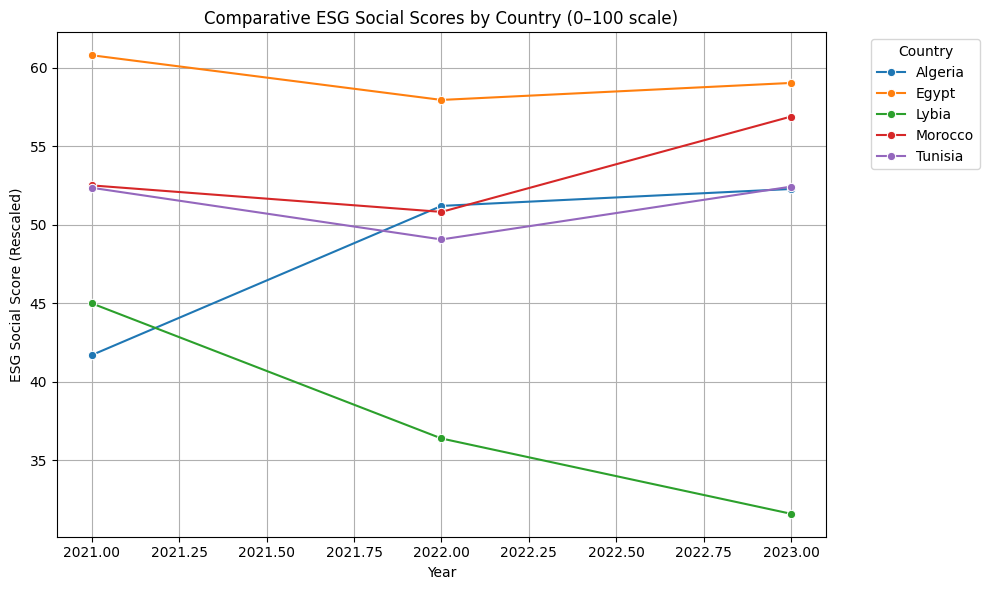

In [68]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="year", y="S_score_avg_rescaled", hue="country", marker="o")

plt.title("Comparative ESG Social Scores by Country (0–100 scale)")
plt.xlabel("Year")
plt.ylabel("ESG Social Score (Rescaled)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()